# UBBR

In [1]:
def randomBoxGenerator(boxes, n=1):
    """
    @param boxes - numpy arraay for compatibility  [[x,y,w,h], [x,y,w,h] ...] N x 4 
    @param n - the number of random boxes per each groundtruth box
    @return n*N x 4
    """
    
    def oneRandomBoxGenerator(boxes):
        """
        Random box generator
        @param boxes -  [[x,y,w,h], [x,y,w,h] ...] N x 4 float tensor
        @return - N x 4 float tensor 
        """
        alpha = 0.35
        beta = 0.5
        n = len(boxes)

        # ground truth boxes    
        x_g = boxes[:,0]
        y_g = boxes[:,1]
        w_g = boxes[:,2]
        h_g = boxes[:,3]

        # sampleing offset parameters
        t_x = torch.rand(n) *2*alpha-alpha
        t_y = torch.rand(n) *2*alpha-alpha
        t_w = torch.rand(n) * torch.tensor((1.0+beta)/(1.0-beta)).log() + torch.tensor((1.0-beta)).log()
        t_h = torch.rand(n) * torch.tensor((1.0+beta)/(1.0-beta)).log() + torch.tensor((1.0-beta)).log()

        # calc random boxes
        x_b = x_g + t_x*w_g
        y_b = y_g + t_y*h_g
        w_b = t_w.exp()*w_g
        h_b = t_h.exp()*h_g

#         print(t_x, t_y, t_w, t_h)A
        return torch.stack([x_b,y_b,w_b,h_b], dim=1), torch.stack([t_x,t_y,t_w,t_h], dim=1)
    
    _rand_boxes = []
    _offsets = []
    for i in range(n):
        b,o = oneRandomBoxGenerator(torch.tensor(boxes, dtype=torch.float)) 
        _rand_boxes.append(b)
        _offsets.append(o)
    rand_boxes = torch.cat(_rand_boxes)
    offsets = torch.cat(_offsets)    
    return rand_boxes.data, offsets.data


In [2]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
import torchvision
# from RoIAlign.roi_align import RoIAlign      # RoIAlign module
# from RoIAlign.roi_align import CropAndResizeFunction # crop_and_resize module
import cv2
import numpy as np
import pandas as pd
import os, shutil
from time import sleep
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

def get_rois(images, featuremaps, bboxes):
    # calc bbox ratio
    ratio_y = featuremaps.shape[2]/images.shape[2]
    ratio_x = featuremaps.shape[3]/images.shape[3]
    bboxes_scaled = bboxes.clone()#.detach()

    bboxes_scaled[:,0] = bboxes_scaled[:,0]*ratio_x # for x
    bboxes_scaled[:,1] = bboxes_scaled[:,1]*ratio_y # for y
    bboxes_scaled[:,2] = bboxes_scaled[:,2]*ratio_x # for w
    bboxes_scaled[:,3] = bboxes_scaled[:,3]*ratio_y # for h

    # x,y,w,h -> x1, y1, x2, y2 그래디언트 학습되는 변수가 아니므로 inplace 계산 들어가도 괜찮다
    bboxes_scaled[:, 2] = bboxes_scaled[:, 0] + bboxes_scaled[:, 2]
    bboxes_scaled[:, 3] = bboxes_scaled[:, 1] + bboxes_scaled[:, 3]
    crops = torchvision.ops.roi_align(featuremaps, [bboxes_scaled], [7,7])
    return crops

class Flatten(torch.nn.Module):
    """
    torch.nn.Sequential에서 사용가능한 flatten 모듈
    """
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)
    
class UBBR(nn.Module):
    def __init__(self):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(UBBR, self).__init__()
#         ****torch pretrained net****
        net = models.resnet50(pretrained=True)
#         modules = list(net.children())[:-3]      # delete all untill Conv_4 layer. - 1024
        modules = list(net.children())[:-2]      # delete all untill Conv_5 layer. - 2048
        avg_pool = torch.nn.AdaptiveAvgPool2d(output_size=(1, 1))
        flatten = Flatten()
        self.backbone = torch.nn.Sequential(*modules) #1024
#         self.backbone = torch.nn.Sequential(*modules, avg_pool, flatten) #1024
    
        # RoIAlign layer
#         self.roi_align = RoIAlign(7, 7) #.to('cuda')
#         self.roi_upsample = nn.UpsamplingBilinear2d([7,7]) # roi-align 대용
        
        # fc layer
        self.fc = nn.Sequential(
#             nn.Conv2d(1024, 16, kernel_size=(1, 1), stride=(1, 1), bias=False),
#             nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            flatten,
            nn.ReLU(),
            nn.Linear(7*7*16, 256, bias=True),
            nn.ReLU(),
            nn.Linear(256, 4, bias=True),
        )
        
        
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.roi_transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                    ])
        
    def forward(self, images, boxes):
        """Extract feature vectors from input images."""
        # CNN backbone
        featuremaps = self.backbone(images)
        
        crops = get_rois(images, featuremaps, boxes)
        
        # fc layer
        offsets = self.fc(crops) 
        return offsets


In [3]:
model = UBBR()
model.to(model.device)

UBBR(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_

## PASCAL VOC

In [4]:
# *********************pascal voc***********************
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',
                'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',
                'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
voc_c2i = {c:i for i,c in enumerate(voc_classes)}

voc_dataset = torchvision.datasets.VOCDetection(root='./data', year='2012', image_set='train', download=False, 
        transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]))
voc_loader = torch.utils.data.DataLoader(voc_dataset, batch_size=1,
                                          shuffle=True, num_workers=4)
# *********************pascal voc***********************

In [5]:
def voc_cvt(data, target):
    """
    voc dataloader를 받아와서 bbox 배치로 내보내줌
    voc dataloader의 batch size는 반드시 1이어야 오류 안남
    """
    global voc_c2i
    _temp_targets = []
    _temp_bboxes = []
    infos =  target['annotation']['object']
    filename =  target['annotation']['filename'][0]
    if(type(infos)==list): # bbox 여러개
        _temp_targets+=list(map(lambda x: x['name'][0], infos))
    else: # bbox 한 개 - 이 경우는 infos가 그냥 dict로 나옴... 더럽네
        _temp_targets += infos['name']
        infos = [infos]
        
    for info in infos:
        x1 = int(info['bndbox']['xmin'][0])
        x2 = int(info['bndbox']['xmax'][0])
        y1 = int(info['bndbox']['ymin'][0])
        y2 = int(info['bndbox']['ymax'][0])
        _temp_bboxes.append([x1,y1,x2-x1,y2-y1]) # x,y,w,h

#     print(_temp_targets)
    targets = np.array([voc_c2i[c] for c in _temp_targets])
    bboxes = np.array(_temp_bboxes)
    return targets, bboxes, filename

In [6]:
# ---------------------------- val set 로드 ---------------------------------
voc_val_dataset = torchvision.datasets.VOCDetection(root='./data', year='2012', image_set='val', download=False, 
        transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])            
    ]))

voc_val_loader = torch.utils.data.DataLoader(voc_val_dataset, batch_size=1,
                                          shuffle=True, num_workers=4)

# *********************
voc_val_dataset_no_normalize = torchvision.datasets.VOCDetection(root='./data', year='2012', image_set='val', download=False, 
        transform=transforms.Compose([
        transforms.ToTensor()            
    ]))

voc_val_loader_no_normalize = torch.utils.data.DataLoader(voc_val_dataset_no_normalize, batch_size=1,
                                          shuffle=True, num_workers=4)

voc_tranmsform = transforms.Compose([
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# ---------------------------- val set 정확도 측정 ---------------------------------

In [7]:
# ------------- non max suppression -------------
# https://wns349.github.io/2018/10/16/nms/

# Calc IOU
def calcIOU(box1, box2):
    """
    box - x,y,w,h
    """    
    area_box1 = box1[2]*box1[3]
    area_box2 = box2[2]*box2[3]
    x1_max = max(box1[0], box2[0])
    x2_min = min(box1[0]+box1[2], box2[0]+box2[2])
    y1_max = max(box1[1], box2[1])
    y2_min = min(box1[1]+box1[3], box2[1]+box2[3])
    
    area_intersection = max(0, x2_min-x1_max) * max(0, y2_min-y1_max)
    area_union = area_box1+area_box2-area_intersection +1e-9
    return area_intersection/area_union

def IOU_loss(box1, box2):
    iou = calcIOU(box1, box2)
    return -1 * (iou +1e-9).log()

def IOU_loss2(ious):
    """
    @params ious - N length tensor
    """
    return -1 * (ious +1e-9).log()    

def non_max_sup_one_class(bboxes, threshold=0.2, descending=False):
    """
    @params threshold - 
    @params ascending - 기본이 내림차순,
    """
    bboxes = list(bboxes)
    bboxes.sort(key = lambda x: x[2], reverse=descending) # 거리값이므로 오름차순, 확률이면 내림차순  
    bboxes = np.array(bboxes)
    keeps = [True]*len(bboxes)

    for i, bbox in enumerate(bboxes):
        if not keeps[i]: continue
        for j in range(i+1, len(bboxes)):
            if not keeps[i]: continue
            iou_res = calcIOU(bbox[0], bboxes[j][0])
            if iou_res>threshold: keeps[j] = False
    return bboxes[keeps]

In [8]:
def regression_transform(bboxes, offsets):
    """
    clac bboxes_adj using offsets
    @params bboxes_adj - N x 4 float tensor
    @params offsets - N x 4 float tensor
    """
    bboxes_adj = bboxes.clone().detach()
    # w,h -> x,y 
    # w,h 값이 x,y계산에 들어가므로 계산순서 바뀌면 안됨
    bboxes[:,2] = bboxes_adj[:,2]/(offsets[:,2].exp()) # w
    _w = bboxes[:,2].clone().detach() # backprop inplace error 방지!!!!!!!!! 중요
    bboxes[:,3] = bboxes_adj[:,3]/(offsets[:,3].exp()) # h
    _h = bboxes[:,3].clone().detach()
    bboxes[:,0] = bboxes_adj[:,0] - offsets[:,0]*_w # x
    bboxes[:,1] = bboxes_adj[:,1] - offsets[:,1]*_h  # y
    
    return bboxes    

# def box_cvt(box):
#     """
#     auto grad possable
#     @params box - N x 4
#     x,y,w,h --> x1,y1,x2,y2
#     """
#     box2 = box.clone().detach().float()
#     box[:,2] = box2[:,0] + box2[:,2]
#     box[:,3] = box2[:,1] + box2[:,3]
#     return box

def box_cvt(box):
    """
    auto grad possable
    @params box - N x 4
    x,y,w,h --> x1,y1,x2,y2
    """
    box2 = box.clone().float()
    box2[:,0] = box[:,0]
    box2[:,1] = box[:,1]
    box2[:,2] = box[:,0] + box[:,2]
    box2[:,3] = box[:,1] + box[:,3]
    return box2

In [23]:
# Observe that all parameters are being optimized
model.train()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

epochs = 15
lossList = []
for epoch in range(epochs):
    print('***************** epoch', epoch, '******************')
    epoch_loss = 0
    for idx, (data, target) in enumerate(voc_loader):
#     for idx in range(2000):   
        optimizer.zero_grad()
        
        # 이미지 짧은쪽 600으로 업샘플링
        #

        # voc 데이터 정제
        targets, bboxes_gt, _f = voc_cvt(data, target)

        # 학습용 랜덤 박스 생성
        bboxes_rand, _o = randomBoxGenerator(bboxes_gt, n=50)
        bboxes_rand_gpu = bboxes_rand.clone().detach().data.to(model.device)

        # UBBR에서 offset 생성
        offsets = model(data.cuda(), bboxes_rand_gpu)

        # reg 적용한 random boxes
        bboxes_adj = regression_transform(bboxes_rand_gpu, offsets)
        
        # 가장 iou가 큰 bboxes_gt 선정
#         losses = [] # 반복문 때문에 느림
#         for box_adj in bboxes_adj:
#             _losses = [IOU_loss(box_adj, box_gt) for box_gt in bboxes_gt]
#             losses.append(min(_losses))
    
        ious = torchvision.ops.box_iou(box_cvt(torch.tensor(bboxes_gt, dtype=torch.float).data.cuda()),
                             box_cvt(bboxes_adj))
        losses = IOU_loss2(ious.max(dim=0).values)
        loss = sum(losses)/len(bboxes_adj)
        epoch_loss += loss

        lossList.append(loss)
        loss.backward()
#         print('[loss]', loss, '\n[params]', list(model.fc.parameters())[-1],
#               '\n[grad]', list(model.fc.parameters())[-1].grad)
        optimizer.step()
        if(idx%20==0):
            print(epoch, idx, '[loss]:', float(loss.data), '[each]:', len(bboxes_gt),
                  '[lr]:', optimizer.state_dict()['param_groups'][0]['lr'])
            
    scheduler.step()
    print('[Epoch]:', epoch, '<<epoch_loss>>', epoch_loss/(idx+1))
    
    PATH = 'torch_models/ubbr-iou-max-'+str(epoch)+'.pt'
    torch.save(model, PATH)

***************** epoch 0 ******************
0 0 [loss]: 1.2029474973678589 [each]: 3 [lr]: 0.001
0 20 [loss]: 0.950007975101471 [each]: 1 [lr]: 0.001
0 40 [loss]: 0.6202269196510315 [each]: 1 [lr]: 0.001
0 60 [loss]: 0.7644779086112976 [each]: 3 [lr]: 0.001
0 80 [loss]: 0.6116240620613098 [each]: 3 [lr]: 0.001
0 100 [loss]: 0.7415268421173096 [each]: 1 [lr]: 0.001
0 120 [loss]: 0.616848886013031 [each]: 3 [lr]: 0.001
0 140 [loss]: 0.7211617827415466 [each]: 2 [lr]: 0.001
0 160 [loss]: 0.6339901089668274 [each]: 2 [lr]: 0.001
0 180 [loss]: 0.4754175841808319 [each]: 1 [lr]: 0.001
0 200 [loss]: 0.56911301612854 [each]: 2 [lr]: 0.001
0 220 [loss]: 0.7998794317245483 [each]: 2 [lr]: 0.001
0 240 [loss]: 0.5862025022506714 [each]: 3 [lr]: 0.001
0 260 [loss]: 0.6727280020713806 [each]: 1 [lr]: 0.001
0 280 [loss]: 0.7649864554405212 [each]: 2 [lr]: 0.001
0 300 [loss]: 0.8061842918395996 [each]: 4 [lr]: 0.001
0 320 [loss]: 0.5257161855697632 [each]: 1 [lr]: 0.001
0 340 [loss]: 0.66367870569229

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type UBBR. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Flatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


***************** epoch 1 ******************
1 0 [loss]: 0.3106585741043091 [each]: 2 [lr]: 0.0005
1 20 [loss]: 0.3823491632938385 [each]: 1 [lr]: 0.0005
1 40 [loss]: 0.48572567105293274 [each]: 1 [lr]: 0.0005
1 60 [loss]: 0.5377370119094849 [each]: 2 [lr]: 0.0005
1 80 [loss]: 0.35691913962364197 [each]: 1 [lr]: 0.0005
1 100 [loss]: 0.2612626850605011 [each]: 1 [lr]: 0.0005
1 120 [loss]: 0.49334320425987244 [each]: 3 [lr]: 0.0005
1 140 [loss]: 0.34918156266212463 [each]: 1 [lr]: 0.0005
1 160 [loss]: 0.662240207195282 [each]: 10 [lr]: 0.0005
1 180 [loss]: 0.35920074582099915 [each]: 1 [lr]: 0.0005
1 200 [loss]: 0.32521480321884155 [each]: 2 [lr]: 0.0005
1 220 [loss]: 0.5109450817108154 [each]: 2 [lr]: 0.0005
1 240 [loss]: 0.6222903728485107 [each]: 4 [lr]: 0.0005
1 260 [loss]: 0.45300737023353577 [each]: 2 [lr]: 0.0005
1 280 [loss]: 0.37081247568130493 [each]: 1 [lr]: 0.0005
1 300 [loss]: 0.25307512283325195 [each]: 1 [lr]: 0.0005
1 320 [loss]: 0.6231188178062439 [each]: 2 [lr]: 0.0005


[Epoch]: 1 <<epoch_loss>> tensor(0.4924, device='cuda:0', grad_fn=<DivBackward0>)
***************** epoch 2 ******************
2 0 [loss]: 0.31170547008514404 [each]: 1 [lr]: 0.00025
2 20 [loss]: 0.3202655613422394 [each]: 2 [lr]: 0.00025
2 40 [loss]: 0.5564674735069275 [each]: 5 [lr]: 0.00025
2 60 [loss]: 0.3911144733428955 [each]: 3 [lr]: 0.00025
2 80 [loss]: 0.711304247379303 [each]: 7 [lr]: 0.00025
2 100 [loss]: 0.6826685070991516 [each]: 4 [lr]: 0.00025
2 120 [loss]: 0.3974391520023346 [each]: 3 [lr]: 0.00025
2 140 [loss]: 0.966900110244751 [each]: 14 [lr]: 0.00025
2 160 [loss]: 0.4125862717628479 [each]: 2 [lr]: 0.00025
2 180 [loss]: 0.28254151344299316 [each]: 1 [lr]: 0.00025
2 200 [loss]: 0.5747635960578918 [each]: 7 [lr]: 0.00025
2 220 [loss]: 0.8703873157501221 [each]: 5 [lr]: 0.00025
2 240 [loss]: 0.5128589272499084 [each]: 3 [lr]: 0.00025
2 260 [loss]: 0.5626015663146973 [each]: 2 [lr]: 0.00025
2 280 [loss]: 0.6651401519775391 [each]: 10 [lr]: 0.00025
2 300 [loss]: 0.473373

2 5580 [loss]: 0.46910250186920166 [each]: 2 [lr]: 0.00025
2 5600 [loss]: 0.2771420478820801 [each]: 1 [lr]: 0.00025
2 5620 [loss]: 0.7359433770179749 [each]: 5 [lr]: 0.00025
2 5640 [loss]: 0.6488561630249023 [each]: 3 [lr]: 0.00025
2 5660 [loss]: 0.49232038855552673 [each]: 2 [lr]: 0.00025
2 5680 [loss]: 0.2576892077922821 [each]: 1 [lr]: 0.00025
2 5700 [loss]: 0.4984481930732727 [each]: 5 [lr]: 0.00025
[Epoch]: 2 <<epoch_loss>> tensor(0.4628, device='cuda:0', grad_fn=<DivBackward0>)
***************** epoch 3 ******************
3 0 [loss]: 0.3516744077205658 [each]: 1 [lr]: 0.000125
3 20 [loss]: 0.2537881135940552 [each]: 1 [lr]: 0.000125
3 40 [loss]: 0.3741328716278076 [each]: 1 [lr]: 0.000125
3 60 [loss]: 0.26883476972579956 [each]: 1 [lr]: 0.000125
3 80 [loss]: 0.4742138981819153 [each]: 2 [lr]: 0.000125
3 100 [loss]: 0.5519542694091797 [each]: 2 [lr]: 0.000125
3 120 [loss]: 0.5673619508743286 [each]: 1 [lr]: 0.000125
3 140 [loss]: 0.49338778853416443 [each]: 4 [lr]: 0.000125
3 160

3 5340 [loss]: 0.6083202362060547 [each]: 4 [lr]: 0.000125
3 5360 [loss]: 0.31197044253349304 [each]: 1 [lr]: 0.000125
3 5380 [loss]: 0.866439700126648 [each]: 8 [lr]: 0.000125
3 5400 [loss]: 0.29651057720184326 [each]: 1 [lr]: 0.000125
3 5420 [loss]: 0.28755947947502136 [each]: 1 [lr]: 0.000125
3 5440 [loss]: 0.2466334104537964 [each]: 1 [lr]: 0.000125
3 5460 [loss]: 0.889312744140625 [each]: 7 [lr]: 0.000125
3 5480 [loss]: 0.5052523016929626 [each]: 1 [lr]: 0.000125
3 5500 [loss]: 0.4749888479709625 [each]: 1 [lr]: 0.000125
3 5520 [loss]: 0.5994420051574707 [each]: 2 [lr]: 0.000125
3 5540 [loss]: 0.26231497526168823 [each]: 1 [lr]: 0.000125
3 5560 [loss]: 0.2548889219760895 [each]: 1 [lr]: 0.000125
3 5580 [loss]: 0.29887861013412476 [each]: 1 [lr]: 0.000125
3 5600 [loss]: 0.6294206976890564 [each]: 4 [lr]: 0.000125
3 5620 [loss]: 0.5554422736167908 [each]: 2 [lr]: 0.000125
3 5640 [loss]: 0.6285428404808044 [each]: 4 [lr]: 0.000125
3 5660 [loss]: 0.8169775009155273 [each]: 6 [lr]: 0.0

4 5100 [loss]: 0.43020179867744446 [each]: 1 [lr]: 6.25e-05
4 5120 [loss]: 0.30169811844825745 [each]: 1 [lr]: 6.25e-05
4 5140 [loss]: 0.5667720437049866 [each]: 6 [lr]: 6.25e-05
4 5160 [loss]: 0.22489610314369202 [each]: 1 [lr]: 6.25e-05
4 5180 [loss]: 0.4323979914188385 [each]: 1 [lr]: 6.25e-05
4 5200 [loss]: 0.6078625917434692 [each]: 2 [lr]: 6.25e-05
4 5220 [loss]: 0.5399914979934692 [each]: 4 [lr]: 6.25e-05
4 5240 [loss]: 0.6458029747009277 [each]: 8 [lr]: 6.25e-05
4 5260 [loss]: 0.3294764757156372 [each]: 1 [lr]: 6.25e-05
4 5280 [loss]: 0.3328382074832916 [each]: 1 [lr]: 6.25e-05
4 5300 [loss]: 0.24928024411201477 [each]: 1 [lr]: 6.25e-05
4 5320 [loss]: 0.29335078597068787 [each]: 1 [lr]: 6.25e-05
4 5340 [loss]: 0.2815149426460266 [each]: 1 [lr]: 6.25e-05
4 5360 [loss]: 0.3579883873462677 [each]: 1 [lr]: 6.25e-05
4 5380 [loss]: 0.5547520518302917 [each]: 4 [lr]: 6.25e-05
4 5400 [loss]: 0.42894262075424194 [each]: 4 [lr]: 6.25e-05
4 5420 [loss]: 0.2754988372325897 [each]: 1 [lr]: 

5 4780 [loss]: 0.6116753220558167 [each]: 5 [lr]: 3.125e-05
5 4800 [loss]: 0.5346651673316956 [each]: 5 [lr]: 3.125e-05
5 4820 [loss]: 0.5638179183006287 [each]: 3 [lr]: 3.125e-05
5 4840 [loss]: 0.5434297919273376 [each]: 7 [lr]: 3.125e-05
5 4860 [loss]: 0.2711074650287628 [each]: 2 [lr]: 3.125e-05
5 4880 [loss]: 0.217396080493927 [each]: 1 [lr]: 3.125e-05
5 4900 [loss]: 0.594591498374939 [each]: 4 [lr]: 3.125e-05
5 4920 [loss]: 0.37407582998275757 [each]: 2 [lr]: 3.125e-05
5 4940 [loss]: 0.5023486018180847 [each]: 4 [lr]: 3.125e-05
5 4960 [loss]: 0.3559143841266632 [each]: 2 [lr]: 3.125e-05
5 4980 [loss]: 0.29477623105049133 [each]: 1 [lr]: 3.125e-05
5 5000 [loss]: 0.6293343305587769 [each]: 5 [lr]: 3.125e-05
5 5020 [loss]: 0.2253103405237198 [each]: 1 [lr]: 3.125e-05
5 5040 [loss]: 0.5042226910591125 [each]: 2 [lr]: 3.125e-05
5 5060 [loss]: 0.3613314628601074 [each]: 1 [lr]: 3.125e-05
5 5080 [loss]: 0.4741288721561432 [each]: 4 [lr]: 3.125e-05
5 5100 [loss]: 0.5661367177963257 [each]

6 4380 [loss]: 0.9002395272254944 [each]: 7 [lr]: 1.5625e-05
6 4400 [loss]: 0.49643638730049133 [each]: 1 [lr]: 1.5625e-05
6 4420 [loss]: 0.41812148690223694 [each]: 3 [lr]: 1.5625e-05
6 4440 [loss]: 0.693494439125061 [each]: 13 [lr]: 1.5625e-05
6 4460 [loss]: 0.726645290851593 [each]: 4 [lr]: 1.5625e-05
6 4480 [loss]: 0.33415064215660095 [each]: 1 [lr]: 1.5625e-05
6 4500 [loss]: 0.26015350222587585 [each]: 1 [lr]: 1.5625e-05
6 4520 [loss]: 0.20319372415542603 [each]: 1 [lr]: 1.5625e-05
6 4540 [loss]: 0.3619705140590668 [each]: 2 [lr]: 1.5625e-05
6 4560 [loss]: 0.6594844460487366 [each]: 2 [lr]: 1.5625e-05
6 4580 [loss]: 0.47024425864219666 [each]: 2 [lr]: 1.5625e-05
6 4600 [loss]: 0.22475986182689667 [each]: 1 [lr]: 1.5625e-05
6 4620 [loss]: 0.42872676253318787 [each]: 2 [lr]: 1.5625e-05
6 4640 [loss]: 0.3518393635749817 [each]: 4 [lr]: 1.5625e-05
6 4660 [loss]: 0.21430595219135284 [each]: 1 [lr]: 1.5625e-05
6 4680 [loss]: 0.3394126296043396 [each]: 1 [lr]: 1.5625e-05
6 4700 [loss]: 0

7 3960 [loss]: 0.6504998207092285 [each]: 6 [lr]: 7.8125e-06
7 3980 [loss]: 0.5892690420150757 [each]: 6 [lr]: 7.8125e-06
7 4000 [loss]: 0.2504808008670807 [each]: 1 [lr]: 7.8125e-06
7 4020 [loss]: 0.29067039489746094 [each]: 1 [lr]: 7.8125e-06
7 4040 [loss]: 0.5890297889709473 [each]: 5 [lr]: 7.8125e-06
7 4060 [loss]: 0.6859597563743591 [each]: 1 [lr]: 7.8125e-06
7 4080 [loss]: 0.6366576552391052 [each]: 7 [lr]: 7.8125e-06
7 4100 [loss]: 0.3862200081348419 [each]: 2 [lr]: 7.8125e-06
7 4120 [loss]: 0.6382626295089722 [each]: 2 [lr]: 7.8125e-06
7 4140 [loss]: 0.2466944456100464 [each]: 1 [lr]: 7.8125e-06
7 4160 [loss]: 0.593899667263031 [each]: 7 [lr]: 7.8125e-06
7 4180 [loss]: 0.45905977487564087 [each]: 2 [lr]: 7.8125e-06
7 4200 [loss]: 0.22116471827030182 [each]: 1 [lr]: 7.8125e-06
7 4220 [loss]: 0.3508158028125763 [each]: 1 [lr]: 7.8125e-06
7 4240 [loss]: 0.6297878623008728 [each]: 6 [lr]: 7.8125e-06
7 4260 [loss]: 0.49650469422340393 [each]: 3 [lr]: 7.8125e-06
7 4280 [loss]: 0.4403

8 3480 [loss]: 0.7881140112876892 [each]: 3 [lr]: 3.90625e-06
8 3500 [loss]: 0.5222458839416504 [each]: 3 [lr]: 3.90625e-06
8 3520 [loss]: 0.5589935183525085 [each]: 2 [lr]: 3.90625e-06
8 3540 [loss]: 0.211486354470253 [each]: 1 [lr]: 3.90625e-06
8 3560 [loss]: 0.47372448444366455 [each]: 5 [lr]: 3.90625e-06
8 3580 [loss]: 0.3978360593318939 [each]: 2 [lr]: 3.90625e-06
8 3600 [loss]: 0.6871356964111328 [each]: 7 [lr]: 3.90625e-06
8 3620 [loss]: 0.23422816395759583 [each]: 1 [lr]: 3.90625e-06
8 3640 [loss]: 0.34211137890815735 [each]: 2 [lr]: 3.90625e-06
8 3660 [loss]: 0.33530452847480774 [each]: 1 [lr]: 3.90625e-06
8 3680 [loss]: 0.2803698182106018 [each]: 1 [lr]: 3.90625e-06
8 3700 [loss]: 0.30166566371917725 [each]: 1 [lr]: 3.90625e-06
8 3720 [loss]: 0.3826652467250824 [each]: 2 [lr]: 3.90625e-06
8 3740 [loss]: 0.21077269315719604 [each]: 1 [lr]: 3.90625e-06
8 3760 [loss]: 0.618108332157135 [each]: 4 [lr]: 3.90625e-06
8 3780 [loss]: 0.575099766254425 [each]: 2 [lr]: 3.90625e-06
8 380

9 2920 [loss]: 0.34786680340766907 [each]: 1 [lr]: 1.953125e-06
9 2940 [loss]: 0.4489406943321228 [each]: 4 [lr]: 1.953125e-06
9 2960 [loss]: 0.6775453090667725 [each]: 6 [lr]: 1.953125e-06
9 2980 [loss]: 0.30143365263938904 [each]: 2 [lr]: 1.953125e-06
9 3000 [loss]: 0.5083166360855103 [each]: 6 [lr]: 1.953125e-06
9 3020 [loss]: 0.6123285293579102 [each]: 2 [lr]: 1.953125e-06
9 3040 [loss]: 0.22164872288703918 [each]: 1 [lr]: 1.953125e-06
9 3060 [loss]: 0.6602758169174194 [each]: 4 [lr]: 1.953125e-06
9 3080 [loss]: 0.3906521499156952 [each]: 2 [lr]: 1.953125e-06
9 3100 [loss]: 0.3038064241409302 [each]: 1 [lr]: 1.953125e-06
9 3120 [loss]: 0.20079132914543152 [each]: 1 [lr]: 1.953125e-06
9 3140 [loss]: 0.3875512480735779 [each]: 2 [lr]: 1.953125e-06
9 3160 [loss]: 0.33886995911598206 [each]: 1 [lr]: 1.953125e-06
9 3180 [loss]: 0.23472960293293 [each]: 1 [lr]: 1.953125e-06
9 3200 [loss]: 0.575456976890564 [each]: 8 [lr]: 1.953125e-06
9 3220 [loss]: 0.2569650709629059 [each]: 1 [lr]: 1.9

10 2300 [loss]: 0.3279089033603668 [each]: 1 [lr]: 9.765625e-07
10 2320 [loss]: 0.253526508808136 [each]: 1 [lr]: 9.765625e-07
10 2340 [loss]: 0.5518264174461365 [each]: 5 [lr]: 9.765625e-07
10 2360 [loss]: 0.7124927043914795 [each]: 11 [lr]: 9.765625e-07
10 2380 [loss]: 0.5522415637969971 [each]: 6 [lr]: 9.765625e-07
10 2400 [loss]: 0.7190558314323425 [each]: 3 [lr]: 9.765625e-07
10 2420 [loss]: 0.19203971326351166 [each]: 1 [lr]: 9.765625e-07
10 2440 [loss]: 0.4841129183769226 [each]: 2 [lr]: 9.765625e-07
10 2460 [loss]: 0.5806965231895447 [each]: 1 [lr]: 9.765625e-07
10 2480 [loss]: 0.7129469513893127 [each]: 9 [lr]: 9.765625e-07
10 2500 [loss]: 0.22260570526123047 [each]: 1 [lr]: 9.765625e-07
10 2520 [loss]: 0.2031499743461609 [each]: 1 [lr]: 9.765625e-07
10 2540 [loss]: 0.2947918772697449 [each]: 3 [lr]: 9.765625e-07
10 2560 [loss]: 0.42493143677711487 [each]: 2 [lr]: 9.765625e-07
10 2580 [loss]: 0.5658255219459534 [each]: 1 [lr]: 9.765625e-07
10 2600 [loss]: 0.41132211685180664 [

11 1600 [loss]: 0.26010552048683167 [each]: 1 [lr]: 4.8828125e-07
11 1620 [loss]: 0.4372086226940155 [each]: 3 [lr]: 4.8828125e-07
11 1640 [loss]: 0.4896162450313568 [each]: 4 [lr]: 4.8828125e-07
11 1660 [loss]: 0.288703978061676 [each]: 1 [lr]: 4.8828125e-07
11 1680 [loss]: 0.2037600725889206 [each]: 1 [lr]: 4.8828125e-07
11 1700 [loss]: 0.4539923667907715 [each]: 3 [lr]: 4.8828125e-07
11 1720 [loss]: 0.44908881187438965 [each]: 3 [lr]: 4.8828125e-07
11 1740 [loss]: 0.7807939648628235 [each]: 4 [lr]: 4.8828125e-07
11 1760 [loss]: 0.5346537232398987 [each]: 3 [lr]: 4.8828125e-07
11 1780 [loss]: 0.25265932083129883 [each]: 1 [lr]: 4.8828125e-07
11 1800 [loss]: 0.4533916711807251 [each]: 3 [lr]: 4.8828125e-07
11 1820 [loss]: 0.23925811052322388 [each]: 1 [lr]: 4.8828125e-07
11 1840 [loss]: 0.4198068082332611 [each]: 2 [lr]: 4.8828125e-07
11 1860 [loss]: 0.5793840885162354 [each]: 5 [lr]: 4.8828125e-07
11 1880 [loss]: 0.4045591652393341 [each]: 1 [lr]: 4.8828125e-07
11 1900 [loss]: 0.3600

12 840 [loss]: 0.30296382308006287 [each]: 1 [lr]: 2.44140625e-07
12 860 [loss]: 0.6093812584877014 [each]: 4 [lr]: 2.44140625e-07
12 880 [loss]: 0.3615760803222656 [each]: 3 [lr]: 2.44140625e-07
12 900 [loss]: 0.6814825534820557 [each]: 4 [lr]: 2.44140625e-07
12 920 [loss]: 0.19240424036979675 [each]: 1 [lr]: 2.44140625e-07
12 940 [loss]: 0.5863656997680664 [each]: 3 [lr]: 2.44140625e-07
12 960 [loss]: 0.4882931113243103 [each]: 2 [lr]: 2.44140625e-07
12 980 [loss]: 0.471668004989624 [each]: 3 [lr]: 2.44140625e-07
12 1000 [loss]: 0.3998313844203949 [each]: 2 [lr]: 2.44140625e-07
12 1020 [loss]: 0.19990277290344238 [each]: 1 [lr]: 2.44140625e-07
12 1040 [loss]: 0.20715944468975067 [each]: 1 [lr]: 2.44140625e-07
12 1060 [loss]: 0.6893343925476074 [each]: 6 [lr]: 2.44140625e-07
12 1080 [loss]: 0.20492185652256012 [each]: 1 [lr]: 2.44140625e-07
12 1100 [loss]: 0.8019718527793884 [each]: 8 [lr]: 2.44140625e-07
12 1120 [loss]: 0.3152303099632263 [each]: 2 [lr]: 2.44140625e-07
12 1140 [loss]

13 0 [loss]: 0.3725961148738861 [each]: 2 [lr]: 1.220703125e-07
13 20 [loss]: 0.24041131138801575 [each]: 1 [lr]: 1.220703125e-07
13 40 [loss]: 0.2440817952156067 [each]: 1 [lr]: 1.220703125e-07
13 60 [loss]: 0.7523901462554932 [each]: 6 [lr]: 1.220703125e-07
13 80 [loss]: 0.4468213617801666 [each]: 3 [lr]: 1.220703125e-07
13 100 [loss]: 0.246281236410141 [each]: 2 [lr]: 1.220703125e-07
13 120 [loss]: 0.19193628430366516 [each]: 1 [lr]: 1.220703125e-07
13 140 [loss]: 0.469655305147171 [each]: 2 [lr]: 1.220703125e-07
13 160 [loss]: 0.6182385087013245 [each]: 4 [lr]: 1.220703125e-07
13 180 [loss]: 0.5444531440734863 [each]: 5 [lr]: 1.220703125e-07
13 200 [loss]: 0.34746360778808594 [each]: 1 [lr]: 1.220703125e-07
13 220 [loss]: 0.29417282342910767 [each]: 1 [lr]: 1.220703125e-07
13 240 [loss]: 0.2693600356578827 [each]: 1 [lr]: 1.220703125e-07
13 260 [loss]: 0.5630337595939636 [each]: 4 [lr]: 1.220703125e-07
13 280 [loss]: 0.23362132906913757 [each]: 1 [lr]: 1.220703125e-07
13 300 [loss]

13 4860 [loss]: 0.37350907921791077 [each]: 1 [lr]: 1.220703125e-07
13 4880 [loss]: 0.24512611329555511 [each]: 1 [lr]: 1.220703125e-07
13 4900 [loss]: 0.2036202996969223 [each]: 1 [lr]: 1.220703125e-07
13 4920 [loss]: 0.5284658074378967 [each]: 4 [lr]: 1.220703125e-07
13 4940 [loss]: 0.7750031352043152 [each]: 5 [lr]: 1.220703125e-07
13 4960 [loss]: 0.6313410401344299 [each]: 2 [lr]: 1.220703125e-07
13 4980 [loss]: 0.4108494818210602 [each]: 2 [lr]: 1.220703125e-07
13 5000 [loss]: 0.7181288599967957 [each]: 5 [lr]: 1.220703125e-07
13 5020 [loss]: 0.6812710165977478 [each]: 4 [lr]: 1.220703125e-07
13 5040 [loss]: 0.3276054561138153 [each]: 1 [lr]: 1.220703125e-07
13 5060 [loss]: 0.7138991951942444 [each]: 4 [lr]: 1.220703125e-07
13 5080 [loss]: 0.5088298916816711 [each]: 1 [lr]: 1.220703125e-07
13 5100 [loss]: 0.47328445315361023 [each]: 2 [lr]: 1.220703125e-07
13 5120 [loss]: 0.8425447940826416 [each]: 7 [lr]: 1.220703125e-07
13 5140 [loss]: 0.6505708694458008 [each]: 6 [lr]: 1.220703

14 3960 [loss]: 0.23245348036289215 [each]: 1 [lr]: 6.103515625e-08
14 3980 [loss]: 0.25320515036582947 [each]: 1 [lr]: 6.103515625e-08
14 4000 [loss]: 0.26721903681755066 [each]: 1 [lr]: 6.103515625e-08
14 4020 [loss]: 0.5486264824867249 [each]: 5 [lr]: 6.103515625e-08
14 4040 [loss]: 0.7074256539344788 [each]: 13 [lr]: 6.103515625e-08
14 4060 [loss]: 0.24789460003376007 [each]: 2 [lr]: 6.103515625e-08
14 4080 [loss]: 0.34473487734794617 [each]: 1 [lr]: 6.103515625e-08
14 4100 [loss]: 0.40880247950553894 [each]: 2 [lr]: 6.103515625e-08
14 4120 [loss]: 0.2057904452085495 [each]: 1 [lr]: 6.103515625e-08
14 4140 [loss]: 0.29563647508621216 [each]: 1 [lr]: 6.103515625e-08
14 4160 [loss]: 0.19228807091712952 [each]: 1 [lr]: 6.103515625e-08
14 4180 [loss]: 0.8799576163291931 [each]: 6 [lr]: 6.103515625e-08
14 4200 [loss]: 0.3027556538581848 [each]: 1 [lr]: 6.103515625e-08
14 4220 [loss]: 0.2963617146015167 [each]: 1 [lr]: 6.103515625e-08
14 4240 [loss]: 0.2872357964515686 [each]: 2 [lr]: 6.

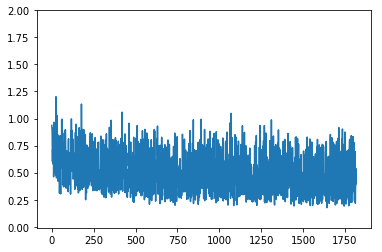

In [11]:
plt.plot(lossList[::10])
plt.ylim(-0.01,2)
plt.show()

In [9]:
"""
Load  UBBR model
"""
LOAD_PATH = 'torch_models/ubbr-iou-max-10.pt'
model = torch.load(LOAD_PATH)

In [10]:
"""랜덤박스 생성 시각화"""
rand_n = 1
IOU_list = {'rand':0, 'adj0':0, 'adj1':0, 'adj2':0}
roi_cnt = 0
SHOW_IMAGE = True # 이미지 볼지 말지
model.eval()

for data, target in tqdm(voc_val_loader_no_normalize):
# for data, target in tqdm(voc_val_loader):
    targets, bboxes_gt, _f = voc_cvt(data, target)
    bboxes_gt = torch.tensor(bboxes_gt).float().data
    roi_cnt += len(bboxes_gt)
    frame = data.mul(255).squeeze().numpy().astype(np.uint8).transpose([1,2,0])
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # opencv image need to convert BGR -> RGB
    
    # GT bbox
    if SHOW_IMAGE:
        for idx, b in enumerate(bboxes_gt):
            x, y, w, h = b
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA) # green

    # random bbox
    bboxes_rand, _offsets = randomBoxGenerator(bboxes_gt, n=rand_n)
    # IOU계산
    _ious = torchvision.ops.box_iou(box_cvt(bboxes_gt), box_cvt(bboxes_rand))
    IOU_list['rand'] += _ious.diag().sum().data
    if SHOW_IMAGE:
        for idx, b in enumerate(bboxes_rand):
            x, y, w, h = b
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 255), 1, cv2.LINE_AA) # yellow
            cv2.putText(frame, 'Rand '+str(idx), (x+3, y+17), cv2.FONT_HERSHEY_SIMPLEX, 
                        fontScale=.6, color=(0,0,0), thickness=2)
        
    # UBBR bbox
    im_tensor = voc_tranmsform(data.squeeze()).to(model.device).unsqueeze(0) # nomalize
    for i  in range(3): # UBBR 연속 적용
        # UBBR에서 offset 생성
        offsets = model(im_tensor, bboxes_rand.cuda())        
        # reg 적용한 random boxes
        bboxes_adj = regression_transform(bboxes_rand, offsets.cpu()) 
        # IOU계산
        _ious = torchvision.ops.box_iou(box_cvt(bboxes_gt), box_cvt(bboxes_adj))
        IOU_list['adj'+str(i)] += _ious.diag().sum().data
        
        if SHOW_IMAGE:
            for idx, b in enumerate(bboxes_adj):
                x, y, w, h = b.clamp(min=-1000, max=1000).int()
                cv2.rectangle(frame, (x, y), (x+w, y+h), (200-i*100, 200-i*100, 255), 1, cv2.LINE_AA) # red   
                cv2.putText(frame, 'UBBR['+str(i)+']'+str(idx), (x+3, y+17), cv2.FONT_HERSHEY_SIMPLEX, 
                            fontScale=.6, color=(0,0,0), thickness=2)     
                
        bboxes_rand = bboxes_adj.clone().detach()

    if SHOW_IMAGE:
        cv2.imshow('frame',frame)
        k = cv2.waitKey(0) & 0xff 
        if k == 27: # esc
            break
        
cv2.destroyAllWindows()
for k in IOU_list:
    print(k, IOU_list[k]/roi_cnt)

  1%|▌                                                                             | 43/5823 [04:22<9:47:03,  6.09s/it]

rand tensor(0.4144)
adj0 tensor(0.5328)
adj1 tensor(0.4677)
adj2 tensor(0.4216)


In [70]:
cv2.destroyAllWindows()

---
# no no

In [61]:
# create 10 random boxes
boxes = torch.rand(10000, 4) * 100
# they need to be in [x0, y0, x1, y1] format
boxes[:, 2:] += boxes[:, :2]
# create a random image
image = torch.rand(1, 3, 200, 200)
# extract regions in `image` defined in `boxes`, rescaling
# them to have a size of 3x3
pooled_regions = torchvision.ops.roi_align(image, [boxes], output_size=(3, 3))
# check the size
print(pooled_regions.shape)
# torch.Size([10, 3, 3, 3])

# or compute the intersection over union between
# all pairs of boxes
print(torchvision.ops.box_iou(boxes, boxes).shape)
# torch.Size([10, 10])

torch.Size([10000, 3, 3, 3])
torch.Size([10000, 10000])


In [18]:
cv2.destroyAllWindows()

In [10]:
criterion = IOU_loss

# Observe that all parameters are being optimized
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

dataloaders = {
    "train": voc_loader,
    "val": voc_val_loader
}

dataset_sizes = {
    "train": len(voc_dataset),
    "val": len(voc_val_dataset)
}

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, save_path):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for idx, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # voc_cvt
                #
                #

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # mini batch statistics
                if idx%50==0:
                    print('[batch loss] {} Loss: {:.4f} Acc: {:.4f}'.format(
                        phase, loss, torch.sum(preds == labels.data)/inputs.shape[0]))

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        #save all model every epoch
        PATH = save_path+str(epoch)+'.pt'
        torch.save(model, PATH)
        print('***** Model saved:', PATH, '*****')
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model